# Northern Ireland Weekly Deaths Exploration

Analysing weekly death registrations in Northern Ireland.

# Usage
Navigate to any section starting with *Configure:* and set the variables as needed for your notebook execution.

# Setup

In [30]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install ipywidgets>=7.6

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [34]:
from lib.utility_functions import local_ca_certificate_file_path, debug_this, Month, download_file, column_convert_object_to_string_in, remove_timestamp
import pandas as pd

In [35]:
import plotly.io as pio
pio.renderers.default = 'notebook'

## Configure: Debugging
The global variable below can be used to enable or disable debug messages.

In [36]:
debug_enabled = True
preview_only_enabled = False

In [37]:
def debug(item):
    debug_this(debug_enabled, item, preview_only_enabled)

# Prepare Deaths Data

You prepare nine datasets for analysis.  

* The first six of these datasets will be prepared from the **Historical Weekly Deaths Data** [published by NISRA here](https://www.nisra.gov.uk/publications/historical-weekly-deaths-data).  
    * NISRA categorises death data as _Historical_ if the date of death registration is on or before 31/12/2020.
* The last three of these datasets will be prepared from the **Weekly Deaths Data** [published by NISRA here](https://www.nisra.gov.uk/statistics/death-statistics/weekly-death-registrations-northern-ireland).


**Historical Weekly Deaths**

*Pre-pandemic Years*
1. 2015 Weekly Deaths.
1. 2016 Weekly Deaths.
1. 2017 Weekly Deaths.
1. 2018 Weekly Deaths.
1. 2019 Weekly Deaths.

*Pandemic Year*
1. 2020 Weekly Deaths.

**Weekly Deaths**

*Post-pandemic Years*
1. 2021 Weekly Deaths.
1. 2022 Weekly Deaths.
1. 2023 Weekly Deaths.

You prepare the most recent data first.

## Weekly Deaths Data

You can find this data at various locations, including: 
* here: https://www.nisra.gov.uk/publications/weekly-death-registrations-northern-ireland-2022.
* here: https://www.nisra.gov.uk/publications/weekly-deaths-week-ending-30-december-2022-and-6-january-2023

### Configure: Current Year Data Coverage

You will always have incomplete data for the current calendar year as the death statistics are published weekly.

You must specify the registration week number (1:52) for which you have data to support inter-year analyses.


In [38]:
analysis_end_week = 32

### Configure: Weekly Download File
1. The URL of the latest source file which changes weekly
2. The number of rows to read

In [39]:
raw_nisra_weekly_deaths_source_url='https://www.nisra.gov.uk/system/files/statistics/Weekly_Deaths%20-%20w%20e%2011%20August%202023.xlsx'
raw_nisra_weekly_deaths_dest_filepath='data/inbound/raw/nisra/deaths/weekly/weekly_deaths.xlsx'
rows_to_read = 171 # Four rows fewer than the row number of the last data point.
#TODO - verify what needs to change here because the latest August 11th spreadsheet only contains 2023 data.

In [40]:
download_file(raw_nisra_weekly_deaths_source_url, raw_nisra_weekly_deaths_dest_filepath)

downloaded from: https://www.nisra.gov.uk/system/files/statistics/Weekly_Deaths%20-%20w%20e%2023%20June%202023.xlsx


In [41]:
df_weekly_deaths = pd.read_excel(raw_nisra_weekly_deaths_dest_filepath,  
                                  sheet_name='Table 3', 
                                  skiprows=3, 
                                  nrows=rows_to_read,
                                  usecols='A:N')
debug(df_weekly_deaths)

,Registration Week,Week Ending (Friday),Antrim & Newtownabbey,Ards & North Down,"Armagh City, Banbridge & Craigavon",Belfast,Causeway Coast & Glens,Derry City & Strabane,Fermanagh & Omagh,Lisburn & Castlereagh,Mid & East Antrim,Mid Ulster,"Newry, Mourne & Down",Total
0,11,19 Mar 2020 to 20 Mar 2020,14,9,10,16,8,12,5,7,9,7,7,104
1,12,2020-03-27 00:00:00,21,27,21,56,34,11,24,20,27,19,27,287
2,13,2020-04-03 00:00:00,24,47,30,100,40,26,21,30,44,26,46,434
3,14,2020-04-10 00:00:00,43,36,25,95,35,17,31,31,39,35,48,435
4,15,2020-04-17 00:00:00,23,46,50,94,28,34,26,41,29,25,28,424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,21,2023-05-26 00:00:00,22,33,48,65,18,24,31,21,27,25,21,335
167,22,2023-06-02 00:00:00,21,35,12,52,20,7,10,20,21,14,23,235
168,23,2023-06-09 00:00:00,21,35,28,50,31,30,17,23,18,20,26,299
169,24,2023-06-16 00:00:00,28,34,31,63,30,22,16,30,34,18,36,342


### Weekly Deaths

We will get the date part only of the Week Ending column. This will allow us to marry this up with other datasets containing the date part only.

In [42]:
default_week_ending_date = '2020-19-03'

def calculate_week_ending_date(week_ending):
    if week_ending == '19 Mar 2020 to 20 Mar 2020':
        return default_week_ending_date
    else:
        return remove_timestamp(week_ending)

In [43]:
df_weekly_deaths['Week Ending (Friday)'] = df_weekly_deaths['Week Ending (Friday)'].astype(str)
df_weekly_deaths['Week Ending Date'] = df_weekly_deaths['Week Ending (Friday)'].apply(lambda raw_week_ending_date: calculate_week_ending_date(raw_week_ending_date))
debug(df_weekly_deaths)

,Registration Week,Week Ending (Friday),Antrim & Newtownabbey,Ards & North Down,"Armagh City, Banbridge & Craigavon",Belfast,Causeway Coast & Glens,Derry City & Strabane,Fermanagh & Omagh,Lisburn & Castlereagh,Mid & East Antrim,Mid Ulster,"Newry, Mourne & Down",Total,Week Ending Date
0,11,19 Mar 2020 to 20 Mar 2020,14,9,10,16,8,12,5,7,9,7,7,104,2020-19-03
1,12,2020-03-27 00:00:00,21,27,21,56,34,11,24,20,27,19,27,287,2020-03-27
2,13,2020-04-03 00:00:00,24,47,30,100,40,26,21,30,44,26,46,434,2020-04-03
3,14,2020-04-10 00:00:00,43,36,25,95,35,17,31,31,39,35,48,435,2020-04-10
4,15,2020-04-17 00:00:00,23,46,50,94,28,34,26,41,29,25,28,424,2020-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,21,2023-05-26 00:00:00,22,33,48,65,18,24,31,21,27,25,21,335,2023-05-26
167,22,2023-06-02 00:00:00,21,35,12,52,20,7,10,20,21,14,23,235,2023-06-02
168,23,2023-06-09 00:00:00,21,35,28,50,31,30,17,23,18,20,26,299,2023-06-09
169,24,2023-06-16 00:00:00,28,34,31,63,30,22,16,30,34,18,36,342,2023-06-16


Rename the columns and change data types for usability reasons.

In [44]:
df_weekly_deaths.rename(columns={
    "Registration Week":"Registration_Week", 
    "Week Ending (Friday)":"Week_end_Date",
    "Total":"Deaths"}, inplace=True
)

df_weekly_deaths = column_convert_object_to_string_in(df_weekly_deaths)

We will save this dataframe for downstream analyses outside of this notebook.

In [45]:
df_weekly_deaths.to_pickle(f'data/outbound/deaths/weekly/PandemicPeriodWeeklyDeathsUpToWeek{analysis_end_week}.pkl')

In [46]:
post_pandemic_years = ['2021', '2022', '2023']

We need to perform some additional wrangling to ensure we only take 52 registration weeks in each year and that all fields are bona fide integers.

In [47]:
from functools import reduce

post_pandemic_weekly_deaths_dfs = {}

for year in post_pandemic_years:

    tmp_df = df_weekly_deaths[(df_weekly_deaths["Week_end_Date"].str.contains(f"{year}", na=False)) & ~((df_weekly_deaths['Registration_Week'] == 52) & 
                                                                               (df_weekly_deaths["Week_end_Date"].str.contains(f"{year}-01")))] \
                [['Registration_Week', 'Deaths']].rename(columns={"Deaths": f"{year}"})
    
    post_pandemic_weekly_deaths_dfs[year] = tmp_df


post_pandemic_weekly_deaths_df = reduce(lambda left,right: pd.merge(left, right, on='Registration_Week', how='left'), list(post_pandemic_weekly_deaths_dfs.values()))

for column in post_pandemic_weekly_deaths_df:
    post_pandemic_weekly_deaths_df[column] = post_pandemic_weekly_deaths_df[column].fillna(0).astype(int)

debug(post_pandemic_weekly_deaths_df)

,Registration_Week,2021,2022,2023
0,1,568,416,474
1,2,443,445,515
2,3,474,317,409
3,4,437,336,393
4,5,462,363,368
5,6,382,375,337
6,7,352,319,402
7,8,351,327,342
8,9,319,338,319
9,10,339,338,334


## Historical Weekly Deaths Data

You can find this data here: https://www.nisra.gov.uk/publications/historical-weekly-deaths-data.

This is where you will find the data for 1-6 above.

In [48]:
raw_nisra_historical_weekly_deaths_source_url='https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/Final%20Historical%20Weekly%20Deaths%20by%20Age%20and%20Respiratory%20Deaths%202011-2021.xlsx'
raw_nisra_historical_weekly_deaths_dest_filepath='data/inbound/raw/nisra/deaths/weekly/historical_weekly_deaths.xlsx'

download_file(raw_nisra_historical_weekly_deaths_source_url, raw_nisra_historical_weekly_deaths_dest_filepath)

downloaded from: https://www.nisra.gov.uk/sites/nisra.gov.uk/files/publications/Final%20Historical%20Weekly%20Deaths%20by%20Age%20and%20Respiratory%20Deaths%202011-2021.xlsx


Firstly, you need to calculate the average and the standard deviation of each registration week for the 2015-2019 period.

In order to do this you need to read data from five individual worksheets inside the historical weekly deaths workbook.


### Historical Weekly Deaths


In [49]:
pre_pandemic_years = ['2015', '2016', '2017', '2018', '2019']

Again, use a few hacks (regex, multiple type casts etc.) to ensure valid integer values for both Registration Week and Number of Deaths.

In [50]:
import pandas as pd
from functools import reduce

pre_pandemic_weekly_deaths_dfs = {}

for year in pre_pandemic_years:

    df = pd.read_excel(raw_nisra_historical_weekly_deaths_dest_filepath,  
                                  sheet_name=f'Weekly Deaths_{year}', 
                                  skiprows=3, 
                                  nrows=52,
                                  usecols='A:D')

    df_tidy = df.rename(columns={"Registration Week":"Registration_Week", f"Total Number of Deaths Registered in Week ({year})":f"{year}"}) \
                .iloc[0:, [0, 3]]
    print(f'Processing {year}...')
    df_tidy['Registration_Week'] = df_tidy['Registration_Week'].astype(str).str.replace("[a-zA-Z]", "", regex=True).astype(float).astype(int)
    df_tidy[f"{year}"] = df_tidy[f"{year}"].astype(int)

    pre_pandemic_weekly_deaths_dfs[year] = df_tidy

Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...


Join the pre-pandemic weekly deaths dataframes together and calculate mean and standard deviation.

In [51]:
pre_pandemic_weekly_deaths_df = reduce(lambda left,right: pd.merge(left,right,on='Registration_Week', how='left'), list(pre_pandemic_weekly_deaths_dfs.values()))

pre_pandemic_weekly_deaths_df[['2015_to_2019_Mean','2015_to_2019_SD']] = pre_pandemic_weekly_deaths_df[pre_pandemic_years] \
                                                                            .agg(['mean', 'std'], axis=1)
debug(pre_pandemic_weekly_deaths_df)

,Registration_Week,2015,2016,2017,2018,2019,2015_to_2019_Mean,2015_to_2019_SD
0,1,319,424,415,481,370,401.8,60.841598
1,2,374,348,434,470,332,391.6,58.538876
2,3,383,372,397,426,335,382.6,33.426038
3,4,397,355,387,432,296,373.4,51.247439
4,5,374,314,371,351,319,345.8,28.225875
5,6,347,310,336,364,342,339.8,19.651972
6,7,328,217,337,366,337,317.0,57.710484
7,8,317,422,351,314,310,342.8,47.198517
8,9,401,298,352,387,342,356.0,40.503086
9,10,345,309,357,359,343,342.6,20.069878


In [52]:
pandemic_weekly_deaths_df = pd.read_excel(raw_nisra_historical_weekly_deaths_dest_filepath,  
                                  sheet_name='Weekly Deaths_2020', 
                                  skiprows=3, 
                                  nrows=52,
                                  usecols='A:Q')

pandemic_weekly_deaths_df = pandemic_weekly_deaths_df \
    .rename(columns={
        "Registration Week":"Registration_Week", 
        "Average number of deaths registered in corresponding week in previous 5 years (2015 to 2019)":"2015_to_2019_Mean", 
        "Minimum in Previous 5 years":"2015_to_2019_Min", 
        "Maximum in Previous 5 years":"2015_to_2019_Max",
        "Total Number of Deaths Registered in Week (2020)":"2020_deaths",
        "Aged >=7 days and < 1 year":"Age_gt_7_days_lt_1_year",
        "Aged 1-14 years":"Age_gte_1_yrs_lte_14_years",
        "Aged 15-44 years":"Age_gte_15_yrs_lte_44_years",
        "Aged 45-64 years":"Age_gte_45_yrs_lte_64_year",
        "Aged 65-74 years":"Age_gte_65_yrs_lte_74_year",
        "Aged 75-84 years":"Age_gte_75_yrs_lte_84_year",
        "Aged 85+ years":"Age_gte_85_yrs",
        "Week Ends (Friday)":"Week_end_date"
    }).iloc[0: , :] \
    .fillna(0) \
    .astype({
        'Registration_Week': int, 
        '2015_to_2019_Mean': float, 
        '2015_to_2019_Min': int, 
        '2015_to_2019_Max': int, 
        '2020_deaths': int, 
        'Age_gt_7_days_lt_1_year': int, 
        'Age_gte_1_yrs_lte_14_years': int, 
        'Age_gte_15_yrs_lte_44_years': int, 
        'Age_gte_45_yrs_lte_64_year': int, 
        'Age_gte_65_yrs_lte_74_year': int, 
        'Age_gte_75_yrs_lte_84_year': int, 
        'Age_gte_85_yrs': int, 
        'Week_end_date': str})\
    .rename(columns={
        "2020_deaths":"2020",
        "Week_end_date":"Week_end_Date"}) \
    [['Registration_Week','2020']]

debug(pandemic_weekly_deaths_df)

,Registration_Week,2020
0,1,394
1,2,410
2,3,347
3,4,323
4,5,332
5,6,306
6,7,297
7,8,347
8,9,312
9,10,324


You now three datasets for analysis:

1. `pre_pandemic_weekly_deaths_df` representing weekly deaths from 2015-2019 inclusive along with the mean and standard deviation for that period.
2. `pandemic_weekly_deaths_df` representing weekly deaths from 2020.
3. `post_pandemic_weekly_deaths_df` representing weekly deaths from 2021-2023.


# Analyse Weekly Deaths Data

You will combine all three datasets above into a single dataframe for convenient analyses.

We will persist these dataframes as CSVs to support analyses outside of this notebook.

In [53]:
all_weekly_deaths_df = reduce(lambda left,right: pd.merge(left, right, on='Registration_Week', how='left'), [pre_pandemic_weekly_deaths_df, pandemic_weekly_deaths_df, post_pandemic_weekly_deaths_df])
debug(all_weekly_deaths_df)

,Registration_Week,2015,2016,2017,2018,2019,2015_to_2019_Mean,2015_to_2019_SD,2020,2021,2022,2023
0,1,319,424,415,481,370,401.8,60.841598,394,568,416,474
1,2,374,348,434,470,332,391.6,58.538876,410,443,445,515
2,3,383,372,397,426,335,382.6,33.426038,347,474,317,409
3,4,397,355,387,432,296,373.4,51.247439,323,437,336,393
4,5,374,314,371,351,319,345.8,28.225875,332,462,363,368
5,6,347,310,336,364,342,339.8,19.651972,306,382,375,337
6,7,328,217,337,366,337,317.0,57.710484,297,352,319,402
7,8,317,422,351,314,310,342.8,47.198517,347,351,327,342
8,9,401,298,352,387,342,356.0,40.503086,312,319,338,319
9,10,345,309,357,359,343,342.6,20.069878,324,339,338,334


### Compute additional averages
We will compute additional averages for each registration week to support analyses across different baselines.

In [54]:
pre_pandemic_weekly_deaths_df[['2015_to_2019_Mean','2015_to_2019_SD']] = pre_pandemic_weekly_deaths_df[pre_pandemic_years] \
                                                                            .agg(['mean', 'std'], axis=1)

all_weekly_deaths_df['2016_to_2020_Mean'] = all_weekly_deaths_df[['2016', '2017', '2018', '2019', '2020']].agg('mean', axis=1)
all_weekly_deaths_df['2017_to_2021_Mean'] = all_weekly_deaths_df[['2017', '2018', '2019', '2020', '2021']].agg('mean', axis=1)
all_weekly_deaths_df['2018_to_2022_Mean'] = all_weekly_deaths_df[['2018', '2019', '2020', '2021', '2022']].agg('mean', axis=1)
all_weekly_deaths_df['2016_to_2019_and_2021_Mean'] = all_weekly_deaths_df[['2016', '2017', '2018', '2019','2021']].agg('mean', axis=1)


debug(all_weekly_deaths_df)

,Registration_Week,2015,2016,2017,2018,2019,2015_to_2019_Mean,2015_to_2019_SD,2020,2021,2022,2023,2016_to_2020_Mean,2017_to_2021_Mean,2018_to_2022_Mean,2016_to_2019_and_2021_Mean
0,1,319,424,415,481,370,401.8,60.841598,394,568,416,474,416.8,445.6,445.8,451.6
1,2,374,348,434,470,332,391.6,58.538876,410,443,445,515,398.8,417.8,420.0,405.4
2,3,383,372,397,426,335,382.6,33.426038,347,474,317,409,375.4,395.8,379.8,400.8
3,4,397,355,387,432,296,373.4,51.247439,323,437,336,393,358.6,375.0,364.8,381.4
4,5,374,314,371,351,319,345.8,28.225875,332,462,363,368,337.4,367.0,365.4,363.4
5,6,347,310,336,364,342,339.8,19.651972,306,382,375,337,331.6,346.0,353.8,346.8
6,7,328,217,337,366,337,317.0,57.710484,297,352,319,402,310.8,337.8,334.2,321.8
7,8,317,422,351,314,310,342.8,47.198517,347,351,327,342,348.8,334.6,329.8,349.6
8,9,401,298,352,387,342,356.0,40.503086,312,319,338,319,338.2,342.4,339.6,339.6
9,10,345,309,357,359,343,342.6,20.069878,324,339,338,334,338.4,344.4,340.6,341.4


We will save this dataset as a CSV and Pickle file for other analyses.

In [55]:
all_weekly_deaths_df.to_pickle(f'data/outbound/deaths/weekly/AllDeathsUpTo2023Week{analysis_end_week}.pkl')
all_weekly_deaths_df.to_csv(f'data/outbound/deaths/weekly/AllDeathsUpTo2023Week{analysis_end_week}.csv', index=False)

In [56]:
all_weekly_deaths_df_copy = all_weekly_deaths_df.copy()
all_weekly_deaths_df_copy['week_name'] = all_weekly_deaths_df_copy.index

melted_df = pd.melt(all_weekly_deaths_df_copy[['Registration_Week', '2015','2016','2017','2018','2019','2020','2021','2022','2023']], id_vars='Registration_Week', var_name='Year', value_name='Weekly_Deaths')
melted_df.head()
melted_df['Year_and_Week'] = melted_df['Year'] + ' Week ' + melted_df['Registration_Week'].astype(str)

sorted_melted_df = melted_df[['Year_and_Week','Weekly_Deaths']].sort_values('Weekly_Deaths', ascending=False).head(20).copy()

In [57]:
# import plotly.io as pio
# pio.renderers.default = 'iframe'
# import plotly.io as pio
# pio.renderers.default = 'notebook'

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

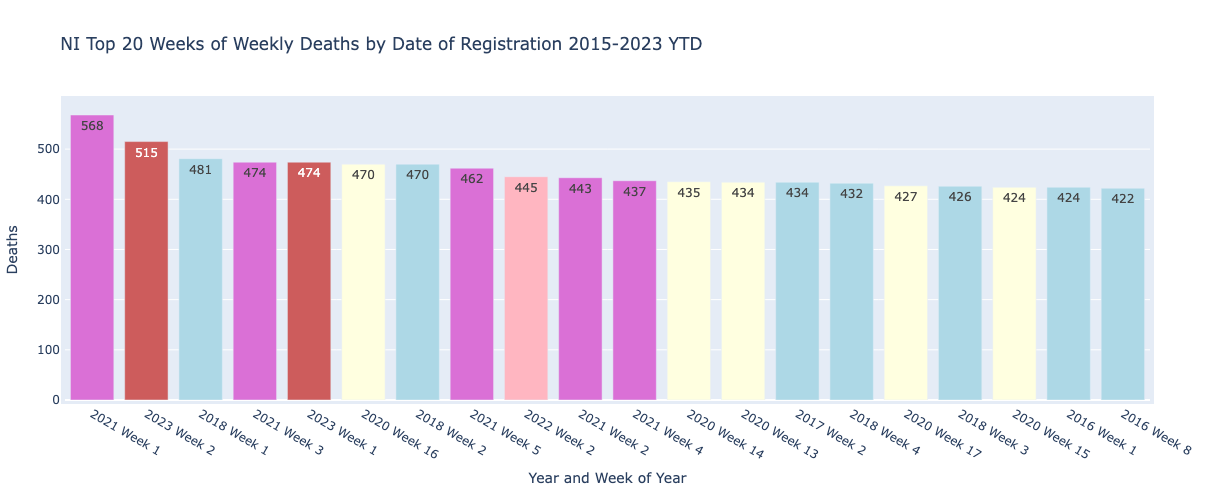

In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set notebook mode to work in offline
#pyo.init_notebook_mode()

my_colors = ["indianred" if '2023' in item else 'lightpink' if '2022' in item else 'orchid' if '2021' in item else 'lightyellow' if '2020' in item else 'lightblue' for item in sorted_melted_df['Year_and_Week']]

fig_layout = go.Layout(
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    title=dict(text="NI Top 20 Weeks of Weekly Deaths by Date of Registration 2015-2023 YTD"),
    xaxis=dict(title_text="Year and Week of Year", type='category'),
    yaxis=dict(title_text="Deaths"),
)

fig_deaths_trends_top20 = make_subplots(specs=[[{"secondary_y": False}]])

def get_color(year_and_week):
    return 'green'

fig_deaths_trends_top20.add_trace(
    go.Bar(
        x=sorted_melted_df['Year_and_Week'], 
        y=sorted_melted_df['Weekly_Deaths'],
        text=sorted_melted_df['Weekly_Deaths'],
        name='Core',
        marker_color=my_colors),
    secondary_y=False)

fig_deaths_trends_final = go.Figure(data=fig_deaths_trends_top20.data, layout=fig_layout)
fig_deaths_trends_final.show()

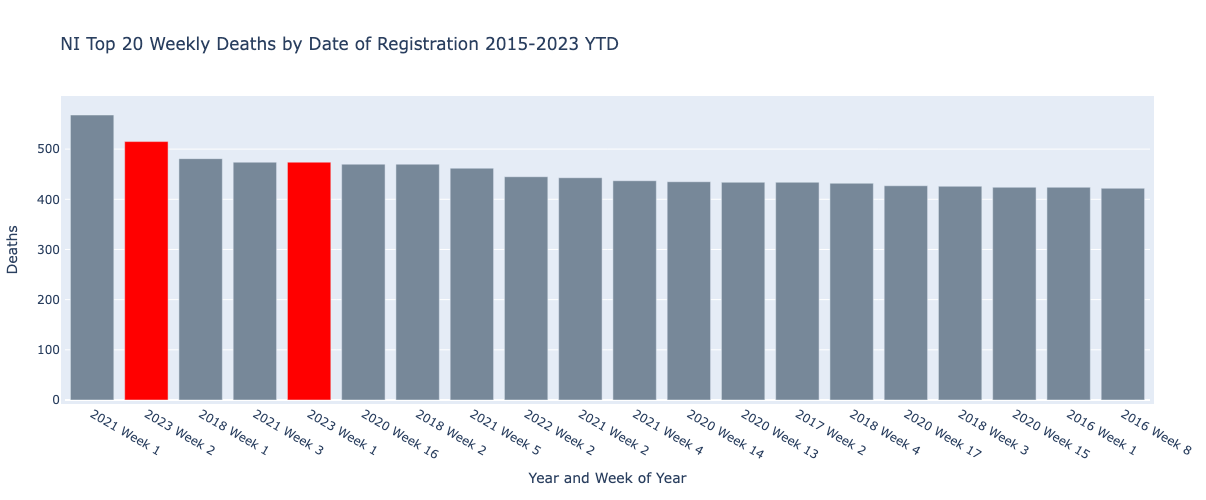

In [59]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

colors = ['lightslategray',] * 20
colors[1] = 'red'
colors[4] = 'red'

fig_layout = go.Layout(
    height=500,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    title=dict(text="NI Top 20 Weekly Deaths by Date of Registration 2015-2023 YTD"),
    xaxis=dict(title_text="Year and Week of Year", type='category'),
    yaxis=dict(title_text="Deaths"),
)

# marker color can be a single color value or an iterable
fig = go.Figure(data=[go.Bar(x=sorted_melted_df['Year_and_Week'],y=sorted_melted_df['Weekly_Deaths'], marker_color=colors)], layout=fig_layout)

fig.update_layout(title_text="NI Top 20 Weekly Deaths by Date of Registration 2015-2023 YTD")

fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

## Heatmap of All Weekly Deaths by Week 2015-2023

In [60]:
subset_df = all_weekly_deaths_df[['2015','2016','2017','2018','2019','2020','2021','2022','2023']].copy()
print(subset_df)
week_numbers = {}
for i in range(52):
    week_number = i + 1
    week_number_text = f'Week {week_number}'
    week_numbers[i] = week_number_text

subset_df.rename(index=week_numbers, inplace=True)
subset_df.style.background_gradient(axis=1)

    2015  2016  2017  2018  2019  2020  2021  2022  2023
0    319   424   415   481   370   394   568   416   474
1    374   348   434   470   332   410   443   445   515
2    383   372   397   426   335   347   474   317   409
3    397   355   387   432   296   323   437   336   393
4    374   314   371   351   319   332   462   363   368
5    347   310   336   364   342   306   382   375   337
6    328   217   337   366   337   297   352   319   402
7    317   422   351   314   310   347   351   327   342
8    401   298   352   387   342   312   319   338   319
9    345   309   357   359   343   324   339   338   334
10   323   292   251   326   294   271   253   301   239
11   310   306   356   319   307   287   307   365   368
12   323   280   314   285   286   434   288   339   306
13   218   295   306   350   301   435   245   355   340
14   293   292   270   280   316   424   289   335   245
15   327   293   245   282   272   470   305   260   345
16   316   305   327   291   35

,2015,2016,2017,2018,2019,2020,2021,2022,2023
Week 1,319,424,415,481,370,394,568,416,474
Week 2,374,348,434,470,332,410,443,445,515
Week 3,383,372,397,426,335,347,474,317,409
Week 4,397,355,387,432,296,323,437,336,393
Week 5,374,314,371,351,319,332,462,363,368
Week 6,347,310,336,364,342,306,382,375,337
Week 7,328,217,337,366,337,297,352,319,402
Week 8,317,422,351,314,310,347,351,327,342
Week 9,401,298,352,387,342,312,319,338,319
Week 10,345,309,357,359,343,324,339,338,334


In [61]:
subset_df.to_csv('data/outbound/deaths/weekly/HeatMapDataUpToWeek25.csv')

## Weekly Deaths for 2020-2023 against 2015-2019 Average

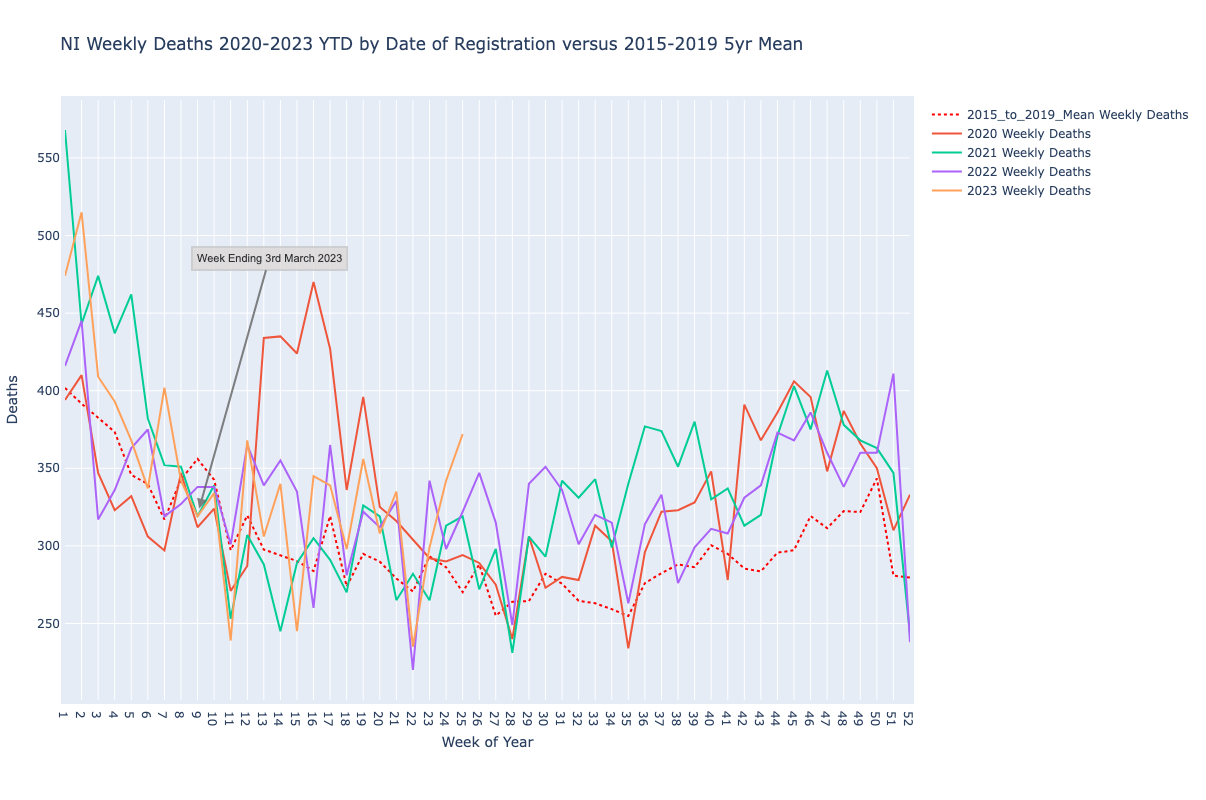

In [62]:
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

fig_deaths_trends = make_subplots(specs=[[{"secondary_y": False}]])

years = ['2015_to_2019_Mean', '2020', '2021', '2022', '2023']

for year in years:
    fig_deaths_trends.add_trace(
        go.Scatter(x=all_weekly_deaths_df['Registration_Week'], 
                   y=all_weekly_deaths_df[year].loc[0:(analysis_end_week - 1)] if year == "2023" else all_weekly_deaths_df[year], 
                   name=f"{year} Weekly Deaths", 
                   line_color = "red" if year == "2015_to_2019_Mean" else None, 
                   line_dash = "dot" if year == "2015_to_2019_Mean" else None),
        secondary_y=False,
    )

layout = go.Layout(
    height=800,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    title=dict(text="NI Weekly Deaths 2020-2023 YTD by Date of Registration versus 2015-2019 5yr Mean"),
    xaxis=dict(title_text="Week of Year", type='category', tickmode = 'linear', tick0 = 1, dtick = 1), 
    yaxis=dict(title_text="Deaths"),
    annotations=[dict(
        x='8.1',
        y=324,
        xref="x",
        yref="y",
        text="Week Ending 3rd March 2023",
        showarrow=True,
        font=dict(family="Arial", size=11, color="#020202"),
        align="left",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=70,
        ay=-250,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8
        )]
)
fig_deaths_trends = go.Figure(data=fig_deaths_trends.data, layout=layout)
fig_deaths_trends.show()
#pio.write_image(fig_deaths_trends, f'data/outbound/deaths/weekly/Deaths_for_2020-2023(Week {analysis_end_week}).png', width=1800, height=1000)

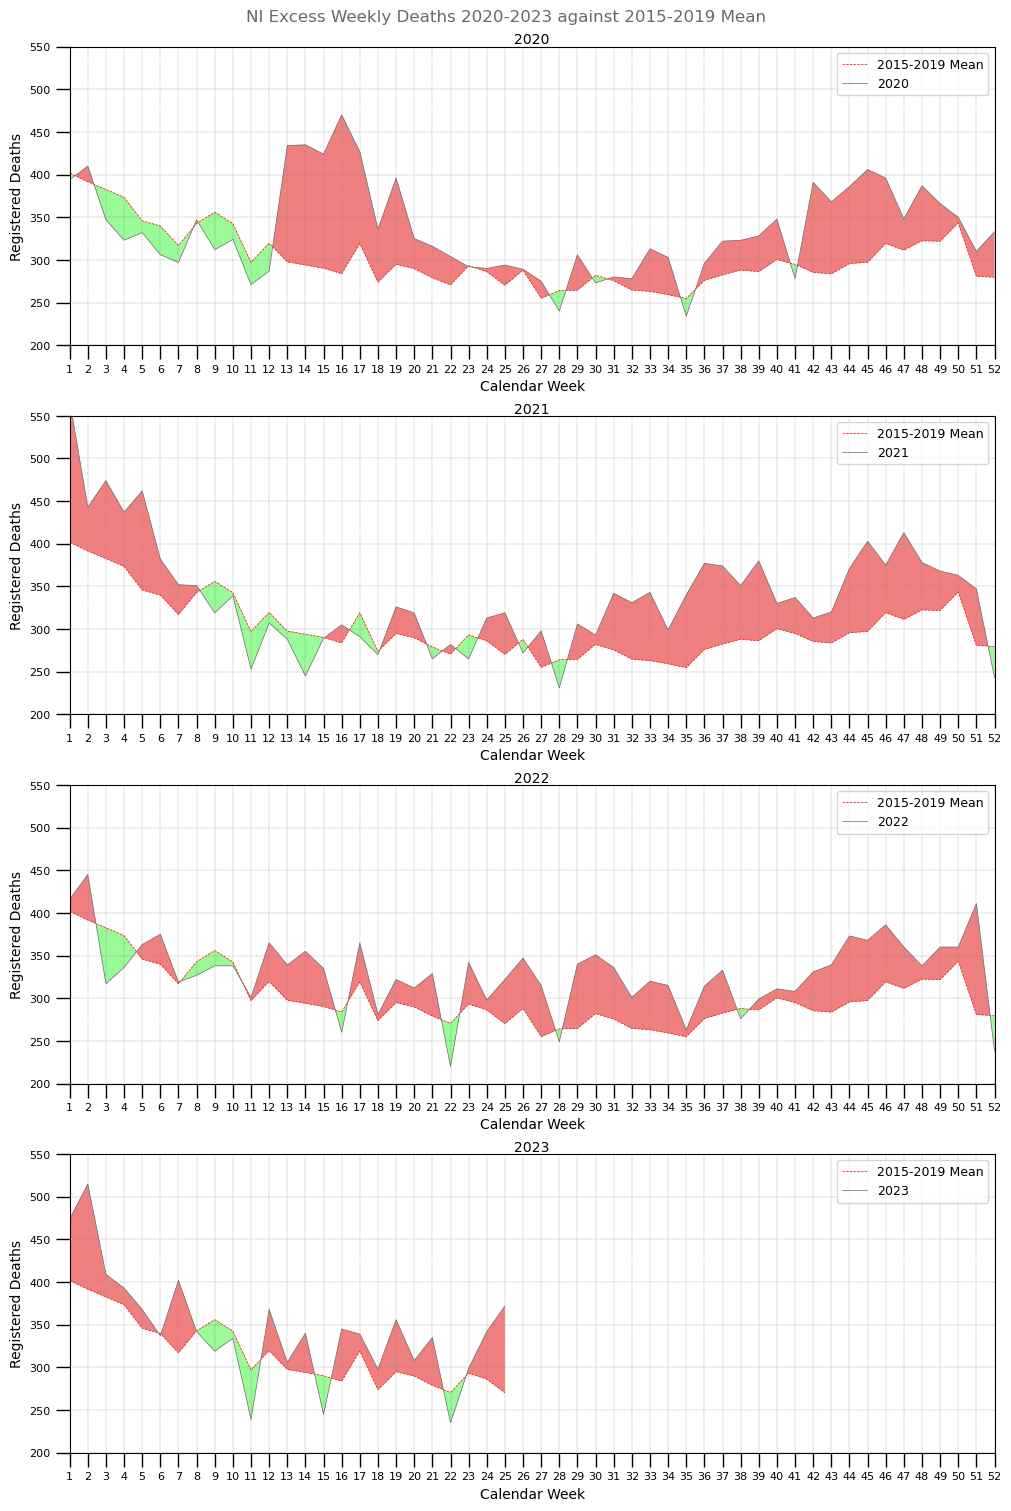

In [63]:
#Let's derive our plot from here - https://matplotlib.org/stable/gallery/showcase/anatomy.html
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(10,15))

fig.suptitle('NI Excess Weekly Deaths 2020-2023 against 2015-2019 Mean', color='dimgrey')

years_to_compare = ['2020', '2021', '2022', '2023']
index=0

for year in years_to_compare:
    
    axs[index].set_title(f"{year}", fontsize=10, verticalalignment='top', color='black')

    x = all_weekly_deaths_df_copy['Registration_Week'].loc[0:(analysis_end_week - 1)] if year == "2023" else all_weekly_deaths_df_copy['Registration_Week']
    y1 = all_weekly_deaths_df_copy['2015_to_2019_Mean'].loc[0:(analysis_end_week - 1)] if year == "2023" else all_weekly_deaths_df_copy['2015_to_2019_Mean']
    
    y2 = all_weekly_deaths_df_copy[f'{year}'].loc[0:(analysis_end_week - 1)] if year == "2023" else all_weekly_deaths_df_copy[f'{year}']
    
    axs[index].set_xlim(1, 52)
    axs[index].set_ylim(200, 550)
    
    axs[index].grid(linestyle="--", linewidth=0.25, color='.5', zorder=-10)

    axs[index].plot(x, y1, color='red', lw=0.5, label="2015-2019 Mean", linestyle="--")
    axs[index].plot(x, y2, color='dimgrey', lw=0.5, label=f'{year}')

    axs[index].fill_between(x, y1, y2, where=y2 >= y1, facecolor='lightcoral', interpolate=True)
    axs[index].fill_between(x, y1, y2, where=y2 <= y1, facecolor='palegreen', interpolate=True)

    axs[index].set_xlabel("Calendar Week", fontsize=10)
    axs[index].set_ylabel("Registered Deaths", fontsize=10)
    
    axs[index].xaxis.set_major_locator(MultipleLocator(1))

    axs[index].tick_params(which='major', width=1.0, length=10, labelsize=8)
    axs[index].tick_params(which='minor', width=1.0, length=5, labelsize=8,labelcolor='0.25')
    
    axs[index].legend(loc="upper right", fontsize=9)
    
    index+=1


plt.savefig(f'data/outbound/deaths/weekly/2020-2023(Week {analysis_end_week})-v-2015-2019-mean-subplots.png')

## Weekly Comparison Against Previous Years

In [64]:
import math

def get_column_value(df, week, column):
    return df.loc[df['Registration_Week'] == week, column].values[0]

def is_higher_or_lower(value):
    if value < 0:
        return "lower than"
    else:
        if value > 0:
            return "higher than"
        else:
            return "(the same as)"

def calculate_percentage_change(first_value, second_value):
    real_difference = (second_value - first_value)

    if first_value !=0:
        percentage = round((real_difference / first_value) * 100, 1)
    else:
        percentage = 0
    return percentage

In [65]:
# Define a list of years to compare against
comparison_years = ['2022', '2021', '2020', '2015_to_2019_Mean']
this_week_2023 = get_column_value(all_weekly_deaths_df, analysis_end_week, '2023')
# Initialize a dictionary to store the results
results = {}

# Loop through each year and calculate the percentage change compared to this_week_2023
for year in comparison_years:
    weekly_deaths = get_column_value(all_weekly_deaths_df, analysis_end_week, year)
    percentage_change = calculate_percentage_change(weekly_deaths, this_week_2023)
    results[f'this_week_{year}_vs_2023'] = percentage_change

# Store the results in a list of tuples for easier iteration
result_tuples = [
    ('2022', results['this_week_2022_vs_2023']),
    ('2021', results['this_week_2021_vs_2023']),
    ('2020', results['this_week_2020_vs_2023']),
    ('2015-2019 average', results['this_week_2015_to_2019_Mean_vs_2023'])
]

print(f'Registration Week {analysis_end_week} in 2023 had {this_week_2023} registered deaths which is:')

# Iterate through the results and print them out
for year, percentage_change in result_tuples:
    percentage_change_abs = abs(percentage_change)
    comparison = is_higher_or_lower(percentage_change)
    print(f' * {percentage_change_abs}% {comparison} week {analysis_end_week} in {year}')


Registration Week 25 in 2023 had 372 registered deaths which is:
 * 15.5% higher than week 25 in 2022
 * 16.6% higher than week 25 in 2021
 * 26.5% higher than week 25 in 2020
 * 37.7% higher than week 25 in 2015-2019 average


## Weekly Deaths Z-Score for 2015-2023 against 2015-2019 Average

In [66]:
year_range = range(2015, 2024)
year_zscore_column_name_suffix = '_zscore_against_2015_to_2019_Mean'

for year in year_range:
    all_weekly_deaths_df[f"{year}{year_zscore_column_name_suffix}"] = \
    (all_weekly_deaths_df[str(year)] - all_weekly_deaths_df["2015_to_2019_Mean"]) / all_weekly_deaths_df["2015_to_2019_SD"]

debug(all_weekly_deaths_df)

,Registration_Week,2015,2016,2017,2018,2019,2015_to_2019_Mean,2015_to_2019_SD,2020,2021,...,2016_to_2019_and_2021_Mean,2015_zscore_against_2015_to_2019_Mean,2016_zscore_against_2015_to_2019_Mean,2017_zscore_against_2015_to_2019_Mean,2018_zscore_against_2015_to_2019_Mean,2019_zscore_against_2015_to_2019_Mean,2020_zscore_against_2015_to_2019_Mean,2021_zscore_against_2015_to_2019_Mean,2022_zscore_against_2015_to_2019_Mean,2023_zscore_against_2015_to_2019_Mean
0,1,319,424,415,481,370,401.8,60.841598,394,568,...,451.6,-1.360911,0.364882,0.216957,1.301741,-0.522669,-0.128202,2.731684,0.233393,1.186688
1,2,374,348,434,470,332,391.6,58.538876,410,443,...,405.4,-0.300655,-0.744804,0.724305,1.339281,-1.018127,0.314321,0.878049,0.912214,2.108001
2,3,383,372,397,426,335,382.6,33.426038,347,474,...,400.8,0.011967,-0.317118,0.430802,1.298389,-1.424040,-1.065038,2.734395,-1.962542,0.789803
3,4,397,355,387,432,296,373.4,51.247439,323,437,...,381.4,0.460511,-0.359042,0.265379,1.143472,-1.510319,-0.983464,1.241038,-0.729793,0.382458
4,5,374,314,371,351,319,345.8,28.225875,332,462,...,363.4,0.999083,-1.126626,0.892798,0.184228,-0.949483,-0.488913,4.116790,0.609370,0.786512
5,6,347,310,336,364,342,339.8,19.651972,306,382,...,346.8,0.366375,-1.516387,-0.193365,1.231429,0.111948,-1.719929,2.147367,1.791169,-0.142479
6,7,328,217,337,366,337,317.0,57.710484,297,352,...,321.8,0.190607,-1.732787,0.346557,0.849066,0.346557,-0.346557,0.606476,0.034656,1.472869
7,8,317,422,351,314,310,342.8,47.198517,347,351,...,349.6,-0.546627,1.678019,0.173734,-0.610189,-0.694937,0.088986,0.173734,-0.334756,-0.016950
8,9,401,298,352,387,342,356.0,40.503086,312,319,...,339.6,1.111026,-1.431990,-0.098758,0.765374,-0.345653,-1.086337,-0.913511,-0.444411,-0.913511
9,10,345,309,357,359,343,342.6,20.069878,324,339,...,341.4,0.119582,-1.674151,0.717493,0.817145,0.019930,-0.926762,-0.179373,-0.229199,-0.428503


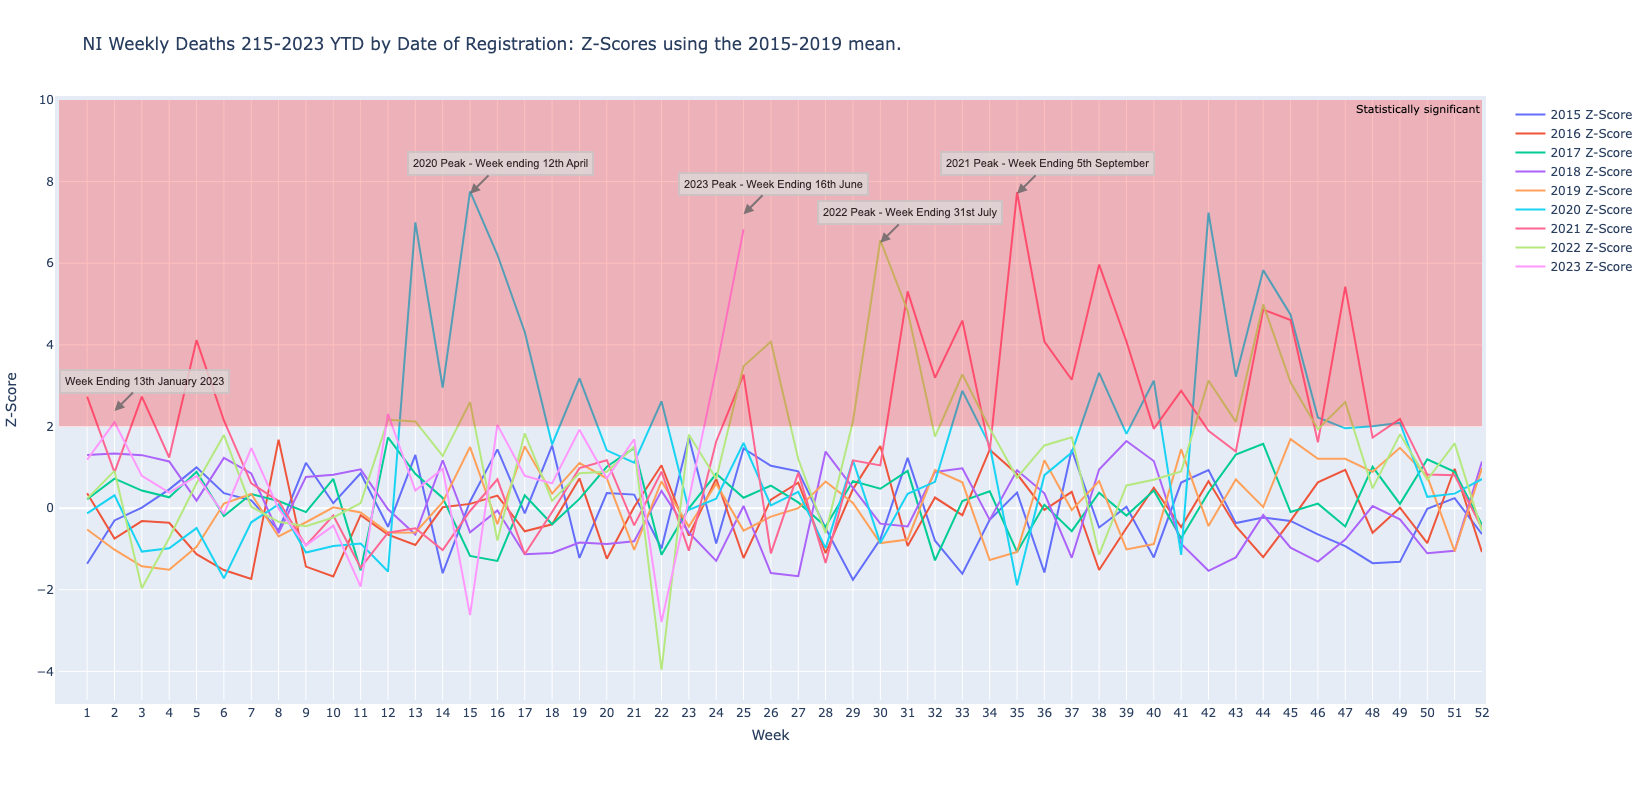

In [70]:
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

fig = make_subplots(specs=[[{"secondary_y": False}]])

for year in years:
    fig.add_trace(
        go.Scatter(x=all_weekly_deaths_df['Registration_Week'], 
                   y=all_weekly_deaths_df[f'{year}_zscore_against_2015_to_2019_Mean'].loc[0:(analysis_end_week - 1)] if year == "2023" else all_weekly_deaths_df[f'{year}_zscore_against_2015_to_2019_Mean'], 
                   name=f"{year} Z-Score"),
        secondary_y=False,)

fig.add_hrect(y0=2, y1=10, annotation_text="Statistically significant", annotation_position="top right", annotation_font_size=11, annotation_font_color="Black", fillcolor="red", opacity=0.25, line_width=0)

annotations = [
    {'x': '29', 'y': 6.5, 'text': '2022 Peak - Week Ending 31st July'},
    {'x': '34', 'y': 7.7, 'text': '2021 Peak - Week Ending 5th September'},
    {'x': '14', 'y': 7.7, 'text': '2020 Peak - Week ending 12th April'},
    {'x': '1', 'y': 2.38, 'text': 'Week Ending 13th January 2023'},
    {'x': '24', 'y': 7.2, 'text': '2023 Peak - Week Ending 16th June'},
]

for annotation in annotations:
    fig.add_annotation(
        x=annotation['x'], 
        y=annotation['y'], 
        xref="x", 
        yref="y", 
        text=annotation['text'], 
        showarrow=True, 
        font=dict(
            family="Arial",
            size=11,
            color="#020202"),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=30,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ddd9d8 ",
        opacity=0.8)

fig.update_layout(
    height=800,
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    title_text="NI Weekly Deaths 215-2023 YTD by Date of Registration: Z-Scores using the 2015-2019 mean.",
    xaxis_title="Week",
    yaxis_title="Z-Score",
    xaxis_type='category'
)

fig.show()